In [2]:
import pandas as pd
import glob
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load basket data
basket_df = pd.read_csv("data/company_basket.csv", sep=";")

# Load all existing Sweden stock data files
sweden_stock_files = glob.glob("data/Sweden_*.txt")

# Load all new data files (both txt and csv)
new_txt_files = glob.glob("data/data-*-*-*.txt")
new_csv_files = glob.glob("data/data-*-*-*.csv")

# Combine all file paths
all_files = sweden_stock_files + new_txt_files + new_csv_files

# Function to read a file based on its extension and path
def read_file(file_path):
    # For existing Sweden files and txt files, use semicolon separator
    if file_path.endswith('.txt'):
        return pd.read_csv(file_path, sep=";")
    # For new CSV files
    elif file_path.endswith('.csv'):
        # If your CSV files also use semicolon separators
        return pd.read_csv(file_path, sep=";")
        # If your CSV files use comma separators, use this instead:
        # return pd.read_csv(file_path)
    else:
        raise ValueError(f"Unsupported file extension for {file_path}")

# Load and concatenate all files
stock_data = pd.concat([read_file(f) for f in all_files])

# Ensure all companies have an industry and sector
stock_data["industry_name"] = stock_data["industry_name"].fillna("Unknown")
stock_data["economic_sector_name"] = stock_data["economic_sector_name"].fillna("Unknown")

# One-hot encode industry_name and economic_sector_name
industry_encoded = pd.get_dummies(stock_data[['company_name', 'industry_name']], columns=['industry_name'])
sector_encoded = pd.get_dummies(stock_data[['company_name', 'economic_sector_name']], columns=['economic_sector_name'])

# Merge one-hot encoded data to create stock_features
stock_features = pd.concat([industry_encoded, sector_encoded.drop("company_name", axis=1)], axis=1)
# Group by company_name to consolidate multiple entries per company
stock_features = stock_features.groupby("company_name").max().astype(int).reset_index()

In [3]:
stock_features.head()
industry_encoded.head()

,company_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Airport Operators & Services,industry_name_Aluminum,industry_name_Apparel & Accessories,industry_name_Apparel & Accessories Retailers,...,industry_name_Software,industry_name_Specialty Chemicals,industry_name_Specialty Mining & Metals,industry_name_Textiles & Leather Goods,industry_name_Tires & Rubber Products,industry_name_Tobacco,industry_name_Toys & Children's Products,industry_name_Unknown,industry_name_Water & Related Utilities,industry_name_Wireless Telecommunications Services
0,Concordia Maritime AB,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Igrene AB (publ),False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Igrene AB (publ),False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Igrene AB (publ),False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Igrene AB (publ),False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [3]:
def create_basket_features(basket_df, stock_features):
    # Convert shares to decimals
    basket_df['company_share'] = basket_df['company_share'] / 100.0
    
    # Get feature columns
    feature_cols = stock_features.columns.drop('company_name')
    
    # Merge and calculate weighted features
    merged = pd.merge(basket_df, stock_features, on='company_name')
    for col in feature_cols:
        merged[col] = merged[col] * merged['company_share']
    
    # Sum features for each basket
    basket_features = merged.groupby('basket_name')[feature_cols].sum()
    
    return basket_features.reset_index()

# Create basket features
basket_features = create_basket_features(basket_df, stock_features)

In [4]:
basket_features.head()

,basket_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Airport Operators & Services,industry_name_Aluminum,industry_name_Apparel & Accessories,industry_name_Apparel & Accessories Retailers,...,economic_sector_name_Consumer Cyclicals,economic_sector_name_Consumer Non-Cyclicals,economic_sector_name_Energy,economic_sector_name_Financials,economic_sector_name_Healthcare,economic_sector_name_Industrials,economic_sector_name_Real Estate,economic_sector_name_Technology,economic_sector_name_Unknown,economic_sector_name_Utilities
0,Air related companies world,0.0,0.0,0.0,0.0,0.680891,0.000822,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.681714,0.000000,0.000000,0.0,0.000000
1,Aluminium,0.0,0.0,0.0,0.0,0.000000,0.000000,0.100000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2,Aussi Fin extra,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.487278,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.063530,0.0,0.000000
3,Aussi Fin extra ny,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.487278,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.063530,0.0,0.000000
4,Austria blended companies,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000618,0.0,0.0,...,0.007801,0.002328,0.200856,0.0,0.0,0.088514,0.192974,0.142613,0.0,0.155768


In [5]:
# Compute cosine similarity matrix (n_basket, n_basket)
similarity_matrix = cosine_similarity(basket_features.iloc[:, 1:].values)

# Get the basket index mapping from unique baskets
basket_to_idx = {name: idx for idx, name in enumerate(basket_features['basket_name'])}

# Function to get similar baskets
def get_similar_baskets(basket_name, similarity_matrix, n=10): 
    if basket_name not in basket_features['basket_name'].values:
        print("\nAvailable baskets:")
        print(sorted(basket_features['basket_name'].unique()))
        raise ValueError(f"\nBasket '{basket_name}' not found in the data")

    # Get index for the target basket
    target_idx = basket_to_idx[basket_name]
    
    similarity_scores = list(enumerate(similarity_matrix[target_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    # Get basket names corresponding to top similar indices
    similar_baskets = [list(basket_to_idx.keys())[i[0]] for i in similarity_scores]

    return similar_baskets

try:
    # Try with a basket name that exists in the data
    similar = get_similar_baskets("BIG INDEX Global", similarity_matrix, n=10)
    print("\nSimilar baskets to 'BIG INDEX Global':")
    print(similar)
except ValueError as e:
    print(e)


Similar baskets to 'BIG INDEX Global':
['EBITDA Sweden', 'German companies', 'Austria business', 'balt business', 'Norweigan super stars', 'WTF…', 'French diversity', 'Consumer Global INDEX', 'Swedish weaked valued', 'Bjorns test 2']


Found rows: 8
Number of unique baskets: 197
Number of baskets in features: 179
Number of baskets in mapping: 179
Missing companies:
                         basket_name                 company_name  \
6        Air related companies world            Bristow Group Inc   
7        Air related companies world         Exchange Income Corp   
9        Air related companies world           Mesa Air Group Inc   
14                         Aussi Fin  Auctus Investment Group Ltd   
15                         Aussi Fin               Barramundi Ltd   
...                              ...                          ...   
3202  US Healthcare medical research     Sangamo Therapeutics Inc   
3236                Why? Dont get it           Standard Supply AS   
3244        World Software companies               Immersion Corp   
3245        World Software companies               Immersion Corp   
3257      World Software companies I               Immersion Corp   

      company_share  
6          0.0963

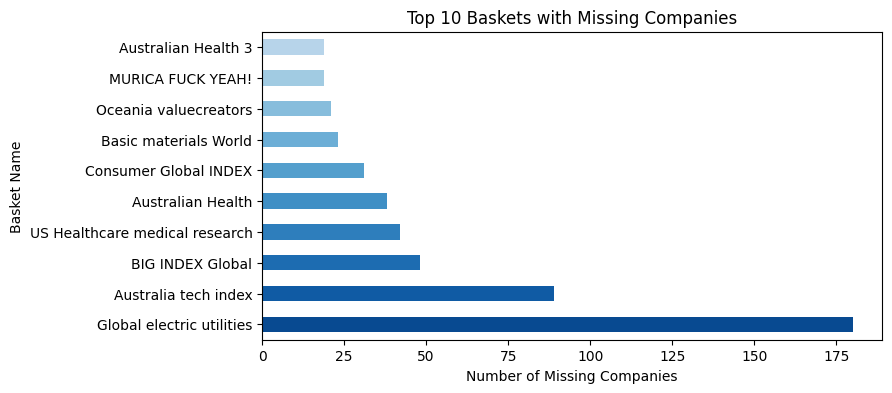

In [6]:
# Debug information
merged = pd.merge(basket_df, stock_features, on='company_name')
merged
wtf_rows = merged[merged['basket_name'] == "WTF II"]
print("Found rows:", len(wtf_rows))

num_baskets = basket_df['basket_name'].nunique()
print(f"Number of unique baskets: {num_baskets}")
print("Number of baskets in features:", len(basket_features))
print("Number of baskets in mapping:", len(basket_to_idx))

# Check companies in basket_df that aren't in stock_features
missing_companies = basket_df[~basket_df['company_name'].isin(stock_features['company_name'])]
print("Missing companies:")
print(missing_companies)

# Check how many companies are lost per basket
lost_companies = missing_companies.groupby('basket_name')['company_name'].count()
lost_companies = lost_companies.sort_values(ascending=False)
n_lost_companies = 10
plt.figure(figsize=(8, 4))
colors = plt.cm.Blues(np.linspace(0.9, 0.3, n_lost_companies))
lost_companies.head(n_lost_companies).plot(kind='barh', color=colors)
plt.title('Top 10 Baskets with Missing Companies')
plt.xlabel('Number of Missing Companies')
plt.ylabel('Basket Name')
print("\nNumber of lost companies per basket:")
print(lost_companies)

In [ ]:
# Filter only Mcap data
mcap_data = stock_data[stock_data["finparametername"] == "Mcap"].copy()

# Ensure Mcap values are numeric
mcap_data["finval"] = pd.to_numeric(mcap_data["finval"], errors='coerce')

# Merge basket data with stock market capitalization
basket_mcap = pd.merge(basket_df, mcap_data[["company_name", "endtime", "finval"]], on="company_name")

# Aggregate Mcap at the basket level
basket_mcap_avg = (
    basket_mcap.groupby("basket_name")["finval"]
    .mean()
    .reset_index()
    .rename(columns={"finval": "avg_mcap"})
)

# Apply Min-Max Scaling to normalize Mcap values
scaler = MinMaxScaler()
basket_mcap_avg["scaled_mcap"] = scaler.fit_transform(basket_mcap_avg[["avg_mcap"]])

# Convert to a DataFrame where rows = baskets and column = scaled Mcap
basket_mcap_features = basket_mcap_avg.set_index("basket_name")[["scaled_mcap"]]

# Compute similarity using Euclidean Distance (negative so that higher = more similar)
similarity_matrix = -euclidean_distances(basket_mcap_features.values)

# Mapping from basket name to index
basket_to_idx = {name: idx for idx, name in enumerate(basket_mcap_avg["basket_name"])}

# Function to find similar baskets based on Mcap using Euclidean Distance
def recommend_basket_based_on_mcap(basket_name, similarity_matrix, top_n=5):
    if basket_name not in basket_to_idx:
        print(f"Basket '{basket_name}' not found. Available baskets: {list(basket_to_idx.keys())}")
        return []
    
    # Get the index of the input basket
    target_idx = basket_to_idx[basket_name]
    
    # Get similarity scores (negative Euclidean Distance)
    similarity_scores = list(enumerate(similarity_matrix[target_idx]))
    
    # Sort in descending order (more similar = less distance)
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Get basket names corresponding to the highest similarity
    similar_baskets = [list(basket_to_idx.keys())[i[0]] for i in similarity_scores]

    return similar_baskets

# Function to validate recommendations by printing Mcap values
def validate_recommendations(input_basket, recommended_baskets, basket_mcap_avg):
    print(f"\nValidating Recommendations for Basket: {input_basket}\n")
    
    # Ensure basket exists
    if input_basket not in basket_mcap_avg["basket_name"].values:
        print(f"Error: '{input_basket}' not found in dataset.")
        return
    
    # Get the Mcap of the input basket
    input_mcap = basket_mcap_avg[basket_mcap_avg["basket_name"] == input_basket]["avg_mcap"].values[0]
    print(f"Input Basket: {input_basket}, Avg Mcap: {input_mcap:,.2f}")
    
    print("\nRecommended Baskets and their Avg Mcap:\n")
    
    for basket in recommended_baskets:
        if basket in basket_mcap_avg["basket_name"].values:
            mcap = basket_mcap_avg[basket_mcap_avg["basket_name"] == basket]["avg_mcap"].values[0]
            print(f"{basket}: Avg Mcap = {mcap:,.2f}")
        else:
            print(f"{basket}: No data available")

# Example: Recommend baskets similar to "BIG INDEX Global" based on market size
recommended_baskets = recommend_basket_based_on_mcap("BIG INDEX Global", similarity_matrix, top_n=5)
print("\nRecommended baskets based on similar Mcap:")
print(recommended_baskets)

# Validate the recommended baskets
validate_recommendations("BIG INDEX Global", recommended_baskets, basket_mcap_avg)


Recommended baskets based on similar Mcap:
['Pharmaceuticals EU', 'Nordic Beers', 'Biotech  EBITDA>0', 'Well traded stocks', 'Consumer Global INDEX']

Validating Recommendations for Basket: BIG INDEX Global

Input Basket: BIG INDEX Global, Avg Mcap: 3,105,319,569.19

Recommended Baskets and their Avg Mcap:

Pharmaceuticals EU: Avg Mcap = 3,091,693,696.24
Nordic Beers: Avg Mcap = 3,178,368,991.23
Biotech  EBITDA>0: Avg Mcap = 3,254,480,228.80
Well traded stocks: Avg Mcap = 2,870,754,544.70
Consumer Global INDEX: Avg Mcap = 2,853,281,033.12
